In [1]:
#for f in `cat jobids/2019-02-*{edsin,sqexp}* | grep -v "#"`; do l=`cat out/$f|grep R-LO`; if [ ! -z "$l" ]; then cat out/$f|grep R-LO|sed -e "s/$/$f/"; fi;done
import pandas as pd
import csv
import pylab
import math
import numpy
import sys
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append('./')
fs = 16
font = {'size'   : fs}
mpl.rc('font', **font)

In [2]:


scal_cols=['code','kernel','m','t1','nb','nmpi','p','q','time','gflops','t2']


hsched_cols2=['sched','m','mb','nnodes','p','q','time','nb','maxsub','minsub','nthreads', 'jobid','iavgrk', 'iminrk', 'imaxrk', 'favgrk', 'fminrk', 'fmaxrk', 'tproblem','tcompress']
colspecv2=['sched','m','mb','nnodes','p','q','time','nb','maxsub','minsub','nthreads', 'jobid','iavgrk', 'iminrk', 'imaxrk', 'favgrk', 'fminrk', 'fmaxrk', 'tproblem','tcompress', 'fixedrank', 'fixedacc','wavek', 'hostname','binary','shmaxrk', 'shprob', 'shdecay']
locolspecv1=['code','m','n','mb','nb','nnodes','p','q','nthreads','shprob','fixedacc','add_diag','fixedrank','wavek','send_full_tile','band','maxrank','shmaxrk','compmaxrank','favgrk', 'fminrk', 'fmaxrk','tcompress','time','jobid']
locolspecv2=['code','m','n','mb','nb','hmb','hnb','nnodes','p','q','nthreads','shprob','shprobstr','fixedacc','add_diag','fixedrank','wavek','send_full_tile','band','lookahead','maxrank','shmaxrk','compmaxrank','favgrk', 'fminrk', 'fmaxrk','tcompress','time','nop','commit','cmd','jobid']
locolspecv3=['code','m','n','mb','nb','hmb','hnb','nnodes','p','q','nthreads','shprob','shprobstr','fixedacc','add_diag','fixedrank','wavek','send_full_tile','band','lookahead','maxrank','shmaxrk','compmaxrank','iavgrk', 'iminrk', 'imaxrk','favgrk', 'fminrk', 'fmaxrk','tcompress','time','nop','commit','cmd','jobid']
fhminmax='res/2017-09-24-hicma-maxrk50-1.txt'
fhminmax='res/2017-10-17-hicma-2M-1.txt'
fhminmax='res/2017-10-17-hicma-2M-2.txt'
fhminmax='res/2017-10-17-hicma-2M-3.txt'
fhicma='res/2017-10-18-hicma-3M-1.txt'
appHicma2Lorapo={2:2, #st-2d-sqexp
                 6:1, #ed-2s-sin
                 13:3, #st-3d-sqexp
                 14:4 #st-3d-exp
                }

global_nplist=[8, 16, 32, 64,128, 256, 512, 1024]
global_nplist=[64,128, 256, 512, 1024]
#df_hicma = df_hicma[df_hicma.m <= 594000]
#df_hicma = df_hicma[df_hicma.m > 594000]
#df_scalm = df_scalm[df_scalm.m > 594000]
#print(df_hicma)

In [3]:
from common import *
#print(katrial)
#print(appmarkers)
#sys.exit()

In [33]:


def fig_finalize(fig, ax, plt, plotname, legncol=2, legloc=4, ylim=None, 
                 xpoints=[80,170,260,350,440,600,800]
                 #, ypoints=[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000]
                 , ypoints=None
                 , title=None, xscale='log', yscale='log'
                ):
    print(plotname)
    #ax.set_xlabel("Matrix size",fontweight='bold')
    #ax.set_ylabel("Time(s)",fontweight='bold')
    
    #proposal
    ax.set_xlabel("Matrix size (N)")
    ax.set_ylabel("Time (s)")
    if ylim is not None: ax.set_ylim(ylim)

    ax.yaxis.grid(True, which='both')
        #ax.set_title('TLR (HiCMA) vs Dense (ScaLAPACK-libsci) POTRF Results on Shaheen')

    if legncol is None:
        legncol=1
    if legloc is None:
        legloc=4
    if legncol == 100:
        #plt.legend(handlelength=3,loc=4, ncol=3, columnspacing=1, bbox_to_anchor=(1.1, 1.05))
        plt.legend(handlelength=3,  loc='center left',      bbox_to_anchor=(1, 0.5))
            #lgd=plt.legend(handlelength=3,loc='lower right',fontsize=12) #, bbox_to_anchor=(1, 0.5))
            #bbox_extra_artists=(lgd,), bbox_inches='tight'
    else:
        plt.legend(handlelength=3,loc=legloc, ncol=legncol, columnspacing=1) #fontsize
 
    print('xscale:',xscale,' yscale:',yscale)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

    if True:
        plt.minorticks_off()
        ax.xaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='major')


        ticks=[i*13500 for i in xpoints ]
        print('xticks', ticks)
        ax.set_xticks(ticks)
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
        #fig.canvas.draw()
        #labels = [str(int(numpy.rint(i*13500/1000000)))+'M' for i in xpoints]
        labels = ["{0:.1f}".format(((i*13500/1000000)))+'M' for i in xpoints]
        print("labels:",labels)
        ax.set_xticklabels(labels)

        fig.canvas.draw()
        ymin, ymax = ax.get_ylim()
        print(ymax, ymin)
        if False and ymax>520:
            tscale = 60.0
            ax.set_ylabel("Time (minutes)") #,fontweight='bold')
        else:
            tscale = 1.0
            ax.set_ylabel("Time (seconds)") #,fontweight='bold')
        
        if ypoints is not None:
            ticks=[i for i in ypoints]
            print('yticks', ticks)
            ax.set_yticks(ticks)
        
#        print([i.get_text() for i in ax.get_yticklabels()])
#        labels = ["{0:.0f}".format(float(i.get_text())/(tscale)) for i in ax.get_yticklabels() ]
#        print("labels:",labels)
#        ax.set_yticklabels(labels)    
        
#        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
        ax.grid(color='gray', linestyle='-', linewidth=.5)
        for child in ax.get_children():
            if isinstance(child, mpl.spines.Spine):
                child.set_color('gray')

    if title is not None:
        ax.set_title(title)
    fig.savefig(plotname+'.pdf', bbox_inches = 'tight');
    plt.show()

    #ax.set_yscale('linear')
    #fig.savefig(plotname+'_ylinear.pdf');
    #plt.show()


def plot(df_hicma, df_scalm, plotname, df_lo=None, show_data_labels=True, show_data=False, yhicma_display_compress=False, 
         nplist=global_nplist, df_hicmaB=None, legncol=None, legloc=None, ylim=None, applist=None, yval='time',        
         xpoints=[80,170,260,350,440,600,800],
         ypoints=None, #[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000],
         colnrows='m',colnumnodes='nnodes',
         title=None, waveklist=None,showdatacols=None, xscale=None, yscale=None
        ):
    #if plotname is not 'time_hsw_cluster':
    #    return
    ax=None
    fig=None
    figsize_width=8
    figsize_height=8
    
    #proposal
    #figsize_width=9
    #figsize_height=5.8
    
    if show_data_labels is True:
        figsize_width=8
        figsize_height=8

    npcolors={8:'red',16:'green',32:'magenta',64:'blue',128:'pink',256:'cyan',512:'black'}
    goodnpcolors={8:'red',16:'#0ca7ab',32:'#59529c',64:'#fa3c3c',128:'#ecaf4d',256:'#6ea35e',512:'#26df2b'#406c9d'
                  ,1024:'blue'}
    """
    HICMA_STARSH_PROB_RND    1
 HICMA_STARSH_PROB_SS     2
 HICMA_STARSH_PROB_RNDUSR 3
 HICMA_STARSH_PROB_FILE   4
 HICMA_STARSH_PROB_GEOSTAT   5
 HICMA_STARSH_PROB_EDSIN  6
 """
    linewidth=2
    if True:
        #fig, ax = plt.subplots(figsize=(figsize_width, figsize_height))
        for app in applist:
            fig, ax = plt.subplots(figsize=(figsize_width, figsize_height))            
            for inp, np in enumerate(nplist):     
                  for hmb in [500,300]: #500, 0
                    #fig, ax = plt.subplots(figsize=(figsize_width, figsize_height))
                    
                    if False:
                        label='StarPU '+appnames[app]+'-'+str(np)# +' nodes'
                        linestyle='-'
                        #marker=appmarkers[app]
                        color='black'
                        #for label,color,marker in [[str(minsub)+' '+sched+' - HiCMA - '+str(np)+' nodes',npcolors[inp],"x"]]:
                        #df=df_hsched[(df_hsched['numnodes']==np)&(df_hsched['sched']==sched)&(df_hsched['iminsub']==minsub)]
                        dfnp=df_hicma[(df_hicma[colnumnodes]==np)&(df_hicma['sched']=='prio')&
                                      (df_hicma['shprob']==app)]
                        if app == 6:
                            dfnp = dfnp[(dfnp['wavek'].isin(waveklist))]
                        df=dfnp.loc[dfnp.groupby([colnrows])["time"].idxmin()]
                        if len(df) == 0:
                            continue
                        if show_data is True:
                            print(label)
                            #print(dfnp[['nnodes','m','mb','nb','minsub','time','jobid','tcompress']])
                            print(df[showdatacols]) #,'wavek'
                        ax=df.plot(ax=ax,x=colnrows, y=yval,ls=linestyle,marker='s',label=label,
                                   color=color,
                                  markersize=markersize*2,mfc='white', mew=markeredgeweight, 
                                   lw=linewidth, zorder=100, clip_on=False)
                        if show_data_labels is True:
                            for xy,m,nb,jobid,time,fminrk,favgrk,fmaxrk in zip(zip(df.m, df.time+500),df.m,df.mb,df.jobid,df.time,df.fminrk,df.favgrk,df.fmaxrk):                                       # <--
                                ax.annotate(str(nb)+' '+str(fminrk)+'\n'+str(favgrk)+' '+str(fmaxrk)+'\n', 
                                            xy=xy, textcoords='data',
                                            ha='center', va='center', size=10) # <--
                        if yhicma_display_compress is True:
                            ax=df.plot(ax=ax,x='m', y='tcompress',ls=None,marker='X',label='$T_{compress}$ - '
                                       +str(np), color=npcolors[inp],markersize=markersize)
                    if True:        
                        for send_full_tile in [1, 0]:
                            for band in [0, 1]:
                                for lookahead in ['-']: #[0, 1, 2, 4]:
                                    if show_data is True: print('Lorapo - '+str(np), 'hmb:'+str(hmb), 'Full tile:'+str(send_full_tile), \
                                             'Band:'+str(band), 'Lookahead:'+str(lookahead))
                                    if band == 1:
                                        locolor='red'
                                    else:
                                        locolor='blue'
                                    if send_full_tile == 1:
                                        lomarker='s'
                                        lolinestyle='-'
                                    else:
                                        lomarker='x'
                                        lolinestyle='-.'
                                    label='PaRSEC '+appnames[app]+'-'+str(np)+' B:'+str(band) + ' F:'+str(send_full_tile)\
                                        #+ ' L:'+str(lookahead)
                                    #label='PaRSEC'
                                    
                                    if hmb == 0:
                                        dfnp = df_lo[(df_lo.nnodes==np) & (df_lo.shprob==appHicma2Lorapo[app])
                                                &(df_lo.band == band) & (df_lo.send_full_tile == send_full_tile)
                                         #       & (df_lo.lookahead == lookahead)
                                                & (df_lo.hmb > 1000)
                                                ]
                                    else:                                        
                                        dfnp = df_lo[(df_lo.nnodes==np) & (df_lo.shprob==appHicma2Lorapo[app])
                                         #       &(df_lo.band == band) & (df_lo.send_full_tile == send_full_tile)
                                         #       & (df_lo.lookahead == lookahead)
                                                 & (df_lo.hmb == hmb)
                                                ]                                                 
                                    if app == 6:
                                        dfnp = dfnp[(dfnp['wavek'].isin(waveklist))]                                    
                                    df=dfnp.loc[dfnp.groupby([colnrows])["time"].idxmin()]
                                    
                                    if len(df) == 0:
                                        continue
                                    ax=df.plot(ax=ax,x='m', y=yval,ls=lolinestyle,marker=lomarker,label=label, 
                                               #color=locolor,#goodnpcolors[np],
                                               markersize=markersize,mfc='white', mew=markeredgeweight, 
                                               lw=linewidth, 
                                               zorder=100, clip_on=False)
                                    if show_data is True:
                                        print(df[['m','mb','hmb','maxrank','time','lookahead','shprobstr','favgrk', 'fminrk', 'fmaxrk','jobid']])
                                    if show_data_labels is True and send_full_tile == 1 and band == 1:
                                        for xy,m,nb,jobid,time,maxrank,fminrk,favgrk,fmaxrk in zip(zip(df.m, df.time),df.m,df.mb,df.jobid,df.time,df.maxrank,df.fminrk,df.favgrk,df.fmaxrk):                                       # <--
                                            ax.annotate(str(nb)+' '+str(maxrank)+'\n'+str(jobid)+'\n', 
                                                xy=xy, textcoords='data',
                                                ha='center', va='center', size=10) # <--
                                break #TODO ignore band
                            break #TODO ignore send_full_tile
                    title=""
                    #title+="Nnodes:"+str(np)
                    title+=' App:'+appnames[app]+ " "
                    if hmb == 0: title+="nonrecursive"#"hmb=nb"
                    else: title+="recursive"#"hmb:"+str(hmb)
                    if False:fig_finalize(fig, ax, plt, plotname+'-'+str(np)+'-'+str(app), legncol, legloc, ylim, \
                                 xpoints, ypoints, title, xscale, yscale)
            fig_finalize(fig, ax, plt, plotname+"_"+appnames[app], legncol, legloc, ylim, xpoints, ypoints, title, xscale, yscale)
    
def process(plotname, hicma_files, scal_files, lorapo_files=None, locolspecs=None, show_data_labels=False, show_data=False, 
            mlowerbound=0, mupperbound=1000000000, yhicma_display_compress=False, nplist=global_nplist,
            hicma_filesB=None, legncol=None, legloc=None, ylim=None,colspecs=None,applist=None,filterfunc=None,
            yval='time',waveklist=None,  
            xpoints=[80,170,260,350,440,600,800],
            ypoints=None, #[200, 330, 400, 500,  800, 1000, 1200, 1800, 2500, 3000, 8000],
            colnrows='m',colnumnodes='nnodes',showdatacols=None,
            title=None, xscale=None, yscale=None
           ):
    frames = []
    if colspecs is None:
        print("define colspecs")
        sys.exit()
    if len(colspecs) != len(hicma_files):
        print("colspecs and hicma_files should have same length")
        sys.exit()
    for ifile, f in enumerate(hicma_files):
        #print(f,colspecs[ifile])
        df = pd.read_csv(f, delim_whitespace=True,engine='python',index_col=False,header=None,names=colspecs[ifile])
        #print(df)
        frames.append(df)
    df_hicma = pd.concat(frames, ignore_index=True)
    #print(df_hicma)
    #return
    #sys.exit()
    if 'shprob' in df_hicma.columns:
        for index, row in df_hicma.iterrows():
            if math.isnan(row['shprob']):    
                df_hicma.set_value(index, 'shprob', 2)  
    else:
        df_hicma['shprob']=2
    if 'shmaxrk' not in df_hicma.columns:
        df_hicma['shmaxrk']=math.nan
    if 'sched' not in df_hicma.columns:
        df_hicma['sched'] = 'prio'
    if 'time' not in df_hicma.columns:
        df_hicma['time'] =  df_hicma['tpotrf']+df_hicma['ttrsm1']+df_hicma['ttrsm2']
    #print(df_hicma)
    #sys.exit()
    framesB = []
    if hicma_filesB is not None:
        for f in hicma_filesB:
            df = pd.read_csv(f, delim_whitespace=True,engine='python',index_col=False,header=None,names=hsched_cols2)
            framesB.append(df)
        df_hicmaB = pd.concat(framesB, ignore_index=True)
        df_hicmaB = df_hicmaB[df_hicmaB[colnrows] > mlowerbound]
        df_hicmaB = df_hicmaB[df_hicmaB[colnrows] < mupperbound]
    else:
        df_hicmaB = pd.DataFrame(columns=hsched_cols2)
        
    if len(scal_files) > 0:
        df_scal = pd.read_csv(scal_files[0], delim_whitespace=True,engine='python',index_col=False,header=None,names=scal_cols)
        df_scalm=df_scal.loc[df_scal.groupby(['m','nmpi'])["nb"].idxmin()]
        df_scalm['nnodes']=df_scalm.nmpi/nmpi_per_node
        df_scalm['nnodes']=df_scalm['nnodes'].astype(int)
        df_scalm = df_scalm[df_scalm['m'] > mlowerbound]
        df_scalm = df_scalm[df_scalm['m'] < mupperbound]
    else:
        df_scalm = pd.DataFrame(columns=scal_cols)
        df_scalm['nnodes']=0
        
    if False and len(lorapo_files) > 0:
        sys.path.append('/Users/akbudak/lorapo/exp/res/')
        import rawparse
        df_lo = rawparse.read_result(lorapo_files[0])
        df_lo['nnodes'] = df_lo['p'] * df_lo['q']
        #print(df_lo)
    frames=[]
    if len(lorapo_files) > 0:
        for ifile, f in enumerate(lorapo_files):
            #print(f,colspecs[ifile])
            df = pd.read_csv(f, skipinitialspace = True, sep=' ',engine='python',quotechar='"',index_col=False,header=None,names=locolspecs[ifile])
            #print(df)
            frames.append(df)
        df_lo = pd.concat(frames, ignore_index=True)
    if yval is "tcompcalc":
        df_hicma['tcompcalc'] = df_hicma['time'] + df_hicma['tcompress']
        
    df_hicma = df_hicma[df_hicma[colnrows] > mlowerbound]
    df_hicma = df_hicma[df_hicma[colnrows] < mupperbound]
    df_lo = df_lo[df_lo[colnrows] < mupperbound]
    df_lo['mK']=(df_lo['m']/1000).astype(int)

    if filterfunc is not None:
        df_hicma=filterfunc(df_hicma)

    if waveklist is not None:
        df_lo = df_lo[(df_lo['wavek'].isin(waveklist))]
    #print(df_hicma)
    df_hicma = df_hicma[df_hicma[colnumnodes] < 1024]
    #dftmp=df_hicma#[df_hicma['shprob']==6.0] 
    #print(df_lo[['shprob','nnodes','m','mb','time','jobid','tcompress']])
    #sys.exit()
    plot(df_hicma, df_scalm, plotname, df_lo, show_data_labels, show_data, yhicma_display_compress, 
         nplist, df_hicmaB, legncol, legloc, ylim,applist, yval, xpoints, ypoints,colnrows,colnumnodes,
         title, waveklist, showdatacols, xscale, yscale
        )
    return df_hicma, df_scalm, df_lo

ed-2d-sin --------------------- 100
parsec_cholesky_ed-2d-sin
xscale: linear  yscale: linear
xticks [1080000, 2160000, 3240000]
labels: ['1.1M', '2.2M', '3.2M']
413.67657 70.64003


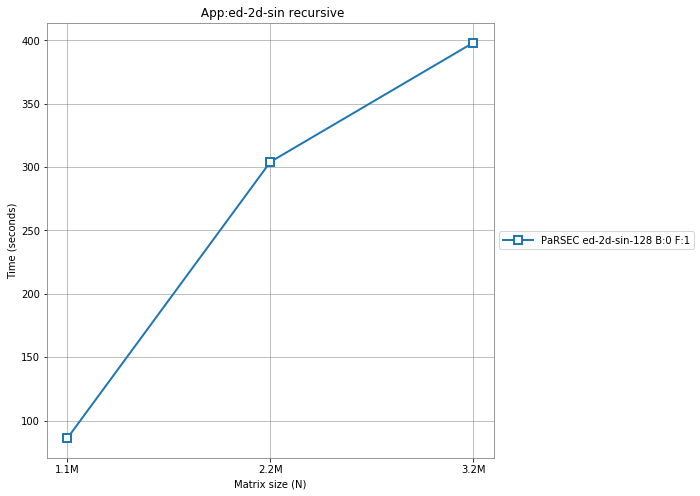

          m    mb  hmb  maxrank      time  shprobstr  wavek    jobid
4   1080000  2700  300      100   86.2326  ed-2d-sin    100  8847316
22  2160000  2700  300      100  304.0780  ed-2d-sin    100  8862587
30  3240000  5400  300      100  398.0840  ed-2d-sin    100  8862592


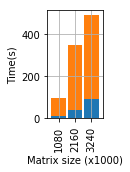

st-2d-sqexp --------------------- 0


/Users/akbudak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


parsec_cholesky_st-2d-sqexp
xscale: linear  yscale: linear
xticks [1080000, 2160000, 3240000]
labels: ['1.1M', '2.2M', '3.2M']
244.90785 46.25115000000001


<Figure size 144x216 with 0 Axes>

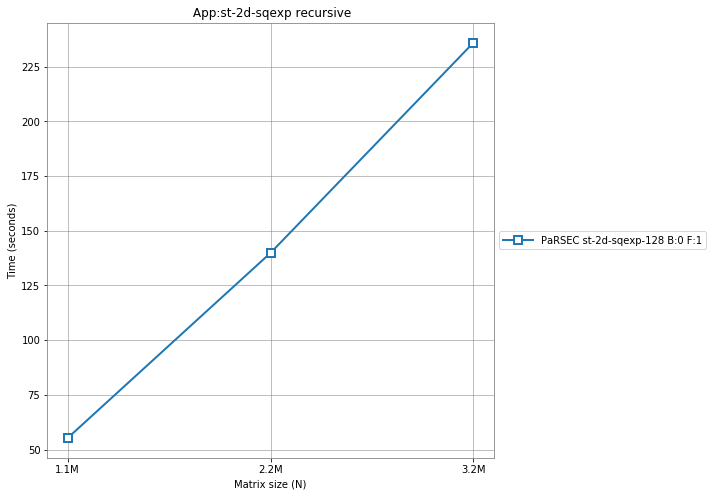

          m    mb  hmb  maxrank     time    shprobstr  wavek    jobid
8   1080000  2700  300       50   55.281  st-2d-sqexp      0  8847317
25  2160000  2700  300       50  139.837  st-2d-sqexp      0  8862588
32  3240000  5400  300       50  235.878  st-2d-sqexp      0  8862593


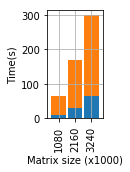

st-3d-sqexp --------------------- 0
parsec_cholesky_st-3d-sqexp
xscale: linear  yscale: linear
xticks [1080000, 2160000, 3240000]
labels: ['1.1M', '2.2M', '3.2M']
1117.95235 135.82065


<Figure size 144x216 with 0 Axes>

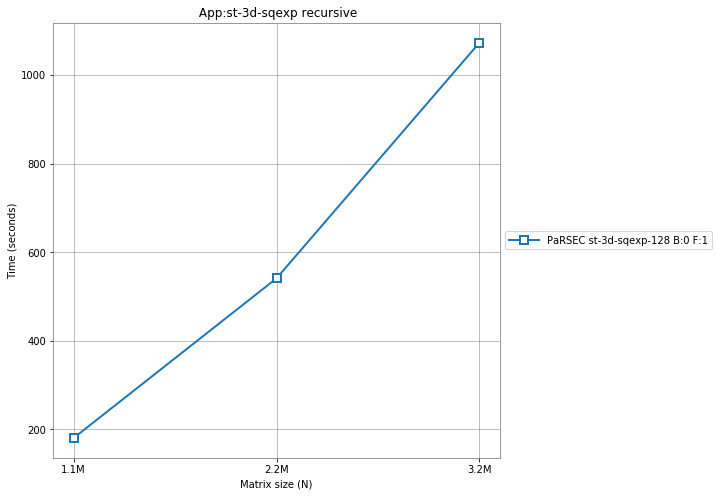

          m    mb  hmb  maxrank      time    shprobstr  wavek    jobid
12  1080000  2700  300      200   180.463  st-3d-sqexp      0  8847318
26  2160000  2700  300      200   541.140  st-3d-sqexp      0  8862589
34  3240000  5400  300      200  1073.310  st-3d-sqexp      0  8862594


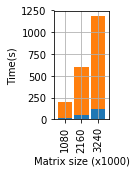

st-3d-exp --------------------- 0
parsec_cholesky_st-3d-exp
xscale: linear  yscale: linear
xticks [1080000, 2160000, 3240000]
labels: ['1.1M', '2.2M', '3.2M']
17675.4715 813.0984999999998


<Figure size 144x216 with 0 Axes>

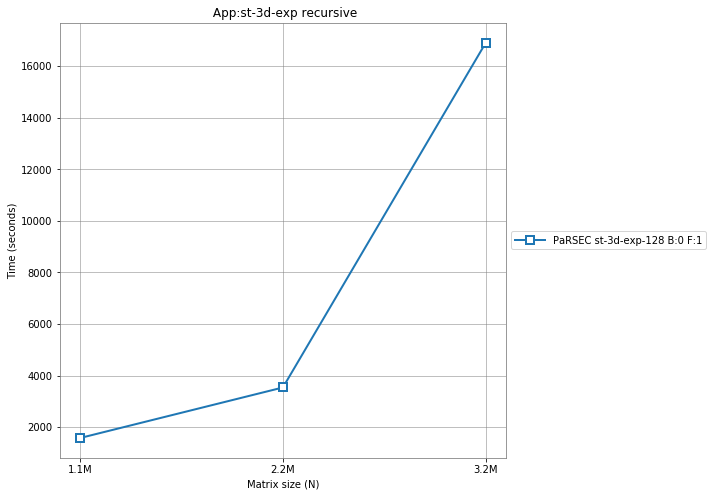

          m    mb  hmb  maxrank      time  shprobstr  wavek    jobid
36  1080000  2400  300     1200   1579.57  st-3d-exp      0  8837040
38  2160000  2400  300     1200   3539.97  st-3d-exp      0  8837040
40  3240000  5400  300     1900  16909.00  st-3d-exp      0  8837040


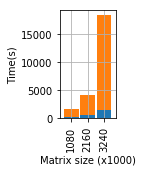

<Figure size 144x216 with 0 Axes>

In [36]:
### TODO
# edsin submitted exp/jobids/2019-02-10-lorapo-edsin-missing-1.txt
# 32   F=1 B=1 5.9 8.1 
# 64   F=0 B=1         10.8
# 64   F=1 B=1     8.1
# 128  F=1 B=1         10.8
#ss submitted exp/jobids/2019-02-10-lorapo-sqexp-missing-1.txt
# 16   F:0 B=1        5.9
# 16   F:1 B=0,1  4.7 5.9
# 32   F=1 B=0,1      5.9 8.1
# 64   all            5.9 8.1 10.8
# 128  F=0 B=0,1              10.8
# 256  all                    10.8
files=['../res/2018-02-17-hicma-edsin-scale-1.txt',
       '../res/2018-04-17-hicma-threads-updatecham-1.txt'
      ]
colspecs=[colspecv2,colspecv2]
florapo=['../res/2019-01-24-lorapo-kadir-use-temp-buff-2.txt']
florapo=['../res/2019-02-04-lorapo-edsin-sqexp-1.txt'] #jobids/2019-02-*{edsin,sqexp}*
locolspecs=[locolspecv1]
florapo=['../res/2019-03-26-lorapo-sqexp2d-1.txt','../res/2019-03-27-lorapo-sqexp3d-1.txt']
locolspecs=[locolspecv2,locolspecv2]
florapo=['../res/2019-04-08-lorapo-breakdown-1.txt'] #timebreakdown
florapo=['../res/2019-04-09-lorapo-breakdown-128-1.txt']
locolspecs=[locolspecv3]
#edsin, 16 nodes, full tile=1, 4.7M is missing, 8126554,8126554, Hicma did not finish, maybe out of memory???
#edsin, 32 nodes, full tile=0, band=1, 8.1M is missing, 8126591, Starsh did not finish
#edsin, 32 nodes, full tile=1, band=0, >5.9M are missing, 8126587, Hicma did not finish
#8126684  Rank 201 [Wed Feb  6 07:53:54 2019] [c2-3c0s13n2] Fatal error in MPI_Testsome: See the MPI_ERROR field in MPI_Status for the error code
#8126685  hicma_hcore.c 365 ERROR in LAPACKE_dgeqrf(1:CU_nrows:3375 2:CU_ncols:-984897850 3:_CU:0x2ab8f735e038 4:ld_CU:3375 5:qrtauA:0x2ab8f82d1178) info=-3 maxrank:150
#ss, 16 nodes, F=1 B=1, 4.7 is missing, 8112021, hicma_hcore.c 45: dpotrf failed with a return value of 1971. uplo:122 m:2700 A:0x2aabc3bb3010 lda:2700
#ss, 16 nodes, F=0, B=1, 5.9 is missing, 8112025, seg fault in starsh

#if True:
applist=[6,2,13,14]   
for app in applist:
    for wavek in [0, 100]: #50
        if app is not 6 and wavek is not 0:
            continue
        if app is 6 and wavek is 0:
            continue
        print(appnames[app], '---------------------', wavek)
        
        df_hicma, df_scalm, df_lo = process(plotname='parsec_cholesky', yval='time',hicma_files=files, 
            #mupperbound=4000000, nplist=[512], xpoints=[80,170,260], 
                    #ypoints=[120,180,240,300, 360,420,480,540,600,900, 1200],
                   # ypoints=[120,240,480,960,1920],
            #        ylim=[100,2000],
            scal_files=[], lorapo_files=florapo, locolspecs=locolspecs, show_data_labels=False, mlowerbound=594000,
            show_data=False, yhicma_display_compress=False, legloc=2, legncol=100, 
            #mupperbound=11000000,xpoints=[80,170,260,350,440,600,800],
            #mupperbound=6000000, xpoints=[80,170,260,350,440],
            mupperbound=6000000, xpoints=[80,160,240],
            title='dpotrf',
            #ylim=[0,50],
            colspecs=colspecs, #applist=[2,6],
            #applist=[2,6,13],
            applist=[app],
            waveklist=[0, wavek],                      
            #nplist=[16,32,64,128,256,512],
            nplist=[128],
            #, ypoints=range(0, 24*60, 60)
            showdatacols=['m','mb','nb','fmaxrk','favgrk','time','shprob','jobid'],
            xscale='linear', yscale='linear'
            ) #,filterfunc=filterfunc2)
        #print(df_lo)
        figsize_width=1
        figsize_height=2
        nnodes=128
        fig, ax = plt.subplots(figsize=(figsize_width, figsize_height))
        df=df_lo[(df_lo['shprob']==appHicma2Lorapo[app])&(df_lo['nnodes']==nnodes)]
        df=df.loc[df.groupby(['m'])["time"].idxmin()]
        if len(df) == 0:
            continue
        print(df[['m','mb','hmb','maxrank','time','shprobstr','wavek','jobid']])
        df[['tcompress','time','mK']].plot(kind='bar', stacked=True,x='mK',ax=ax,width=.9)
        #df_scalm[['tcompress','tcompcalc','m']].plot(kind='bar', stacked=True,x='m',ax=ax)
        ax.set_xlabel("Matrix size (x1000)")
        ax.set_ylabel("Time(s)")
        legend = ax.legend(['Generation&compression','Cholesky']);
        legend.remove()
        plt.grid()
        fig.savefig('stacked-lorapo_'+str(nnodes)+'_'+str(appnames[app])+'_'+str(wavek)+'.pdf', bbox_inches = 'tight');
        plt.show()
        figlegend = pylab.figure(figsize=(2,3))
        legend = pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper left', ncol=2)
        
        #figlegend.legend(('Generation&compression','Cholesky'))
        legend.get_texts()[0].set_text('Generation&Compression')
        legend.get_texts()[1].set_text('Cholesky')
        figlegend.show()
        figlegend.savefig('stacked-lorapo-legend.pdf', bbox_inches = 'tight')
        #break
    #break
if False:process(plotname='starpu_parsec_generation', yval='tcompress',hicma_files=files, 
        scal_files=[], lorapo_files=florapo, show_data_labels=False, mlowerbound=594000,
        show_data=False, yhicma_display_compress=False, legloc=2, ylim=[4,700], 
        colspecs=colspecs, applist=[6],waveklist=[50],
        xpoints=[80,170,260,350,440],
#        ypoints=[4,8,12,16,20,24,32,64,128,256,512], 
                 ypoints=range(120, 480, 60),
                 title='Generation'
        ) #,filterfunc=filterfunc2)